In [3]:
%pip install tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
#Dataset
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Path to dataset files: C:\Users\Skynet\.cache\kagglehub\datasets\jonathanoheix\face-expression-recognition-dataset\versions\1


<h1>UCITAVANJE PODATAKA SA OVERSAMPLINGOM ZA DISGUST</h1>

In [5]:
#dodato novo sa oversamplingom
import tensorflow as tf
import numpy as np

# --- Parametri ---
# train_val_data_dir = r'..\images\train'
train_val_data_dir = path + r'\images\train'
img_height = 48
img_width = 48
batch_size = 128
target_class = 'disgust'
target_count = 4000

# --- Učitaj sve slike u memoriju (kao test DS, bez split) ---
all_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=1,   # batch=1 da dobijemo pojedinačne slike
    shuffle=True,
    color_mode='grayscale'
)

class_names = all_ds.class_names
num_classes = len(class_names)
target_idx = class_names.index(target_class)
print("Sve klase:", class_names)

# --- Razdvoji slike po klasama ---
images_per_class = {i: [] for i in range(num_classes)}
labels_per_class = {i: [] for i in range(num_classes)}

for img, lbl in all_ds.unbatch():
    cls_idx = tf.argmax(lbl).numpy()
    images_per_class[cls_idx].append(img.numpy())
    labels_per_class[cls_idx].append(lbl.numpy())

# --- Oversampling ciljne klase ---
current_count = len(images_per_class[target_idx])
if current_count < target_count:
    extra_idx = np.random.choice(current_count, target_count - current_count, replace=True)
    for i in extra_idx:
        images_per_class[target_idx].append(images_per_class[target_idx][i])
        labels_per_class[target_idx].append(labels_per_class[target_idx][i])

# --- Spoji sve klase ---
all_images = []
all_labels = []
for i in range(num_classes):
    all_images.extend(images_per_class[i])
    all_labels.extend(labels_per_class[i])

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# --- Permutacija da batch-evi budu mešani ---
perm = np.random.permutation(len(all_images))
all_images = all_images[perm]
all_labels = all_labels[perm]

# --- Stratified split 80/20 po klasama ---
train_images, val_images = [], []
train_labels, val_labels = [], []

for cls in range(num_classes):
    cls_indices = np.where(np.argmax(all_labels, axis=1) == cls)[0]
    split_idx = int(len(cls_indices) * 0.8)
    train_idx = cls_indices[:split_idx]
    val_idx = cls_indices[split_idx:]
    
    train_images.append(all_images[train_idx])
    train_labels.append(all_labels[train_idx])
    val_images.append(all_images[val_idx])
    val_labels.append(all_labels[val_idx])

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)
val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# --- Permutacija nakon split-a ---
perm_train = np.random.permutation(len(train_images))
train_images = train_images[perm_train]
train_labels = train_labels[perm_train]

perm_val = np.random.permutation(len(val_images))
val_images = val_images[perm_val]
val_labels = val_labels[perm_val]

# --- Kreiraj batch-eve kao image_dataset_from_directory ---
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))  # shuffle pre batch-a
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.shuffle(buffer_size=len(val_images))  # opcionalno, obično se ne shuffle val
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


train_ds.class_names = class_names
val_ds.class_names = class_names

print("Train shape:", train_images.shape, train_labels.shape)
print("Val shape:", val_images.shape, val_labels.shape)


Found 28821 files belonging to 7 classes.
Sve klase: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train shape: (25906, 48, 48, 1) (25906, 7)
Val shape: (6479, 48, 48, 1) (6479, 7)


In [6]:
# test DS
batch_size = 128
# test_data_dir = r'..\images\test'
test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False 
)

test_class_names = test_ds.class_names
print(test_class_names)

Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Broj slika u originalnom datasetu:
        
        - training 28821
        
        - validation (test kod nas) 7066

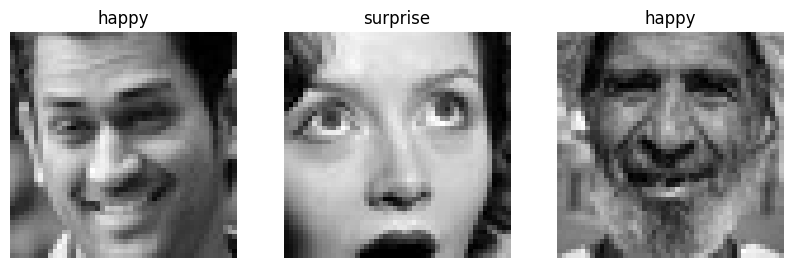

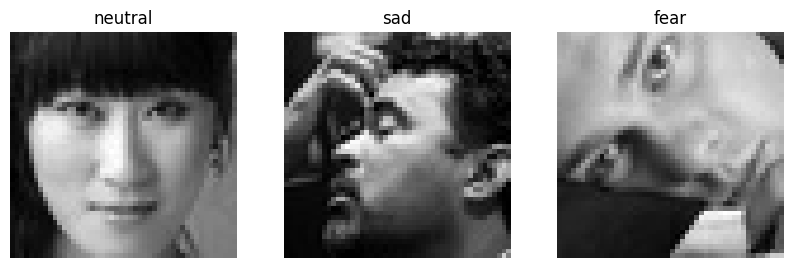

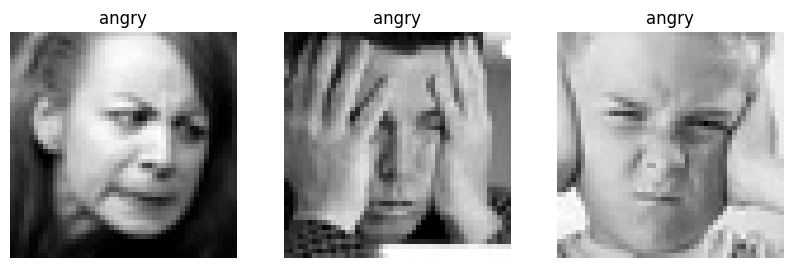

In [40]:
import matplotlib.pyplot as plt

train_class_names = train_ds.class_names
class_names = train_class_names
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  
    for i in range(3): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray") 
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

class_names = val_ds.class_names
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):  
    for i in range(3): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray") 
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")


class_names = test_class_names
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):  
    for i in range(3): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray") 
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

In [35]:
def count_labels_with_percentage(dataset, class_names):
    counts = dict.fromkeys(class_names, 0)
    total = 0
    
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[class_names[i]] += 1
        total += len(indices)
    percentages = {cls: f"{(counts[cls]/total)*100:.2f}%" for cls in class_names}
    
    return counts, percentages


train_counts, train_perc = count_labels_with_percentage(train_ds, class_names)
val_counts, val_perc = count_labels_with_percentage(val_ds, class_names)
test_counts, test_perc = count_labels_with_percentage(test_ds, class_names)

print("Train dataset counts:", train_counts)
print("Train dataset %:", train_perc)

print("\nValidation dataset counts:", val_counts)
print("Validation dataset %:", val_perc)

print("\nTest dataset counts:", test_counts)
print("Test dataset %:", test_perc)


Train dataset counts: {'angry': 3194, 'disgust': 3200, 'fear': 3282, 'happy': 5731, 'neutral': 3985, 'sad': 3950, 'surprise': 2564}
Train dataset %: {'angry': '12.33%', 'disgust': '12.35%', 'fear': '12.67%', 'happy': '22.12%', 'neutral': '15.38%', 'sad': '15.25%', 'surprise': '9.90%'}

Validation dataset counts: {'angry': 799, 'disgust': 800, 'fear': 821, 'happy': 1433, 'neutral': 997, 'sad': 988, 'surprise': 641}
Validation dataset %: {'angry': '12.33%', 'disgust': '12.35%', 'fear': '12.67%', 'happy': '22.12%', 'neutral': '15.39%', 'sad': '15.25%', 'surprise': '9.89%'}

Test dataset counts: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}
Test dataset %: {'angry': '13.59%', 'disgust': '1.57%', 'fear': '14.41%', 'happy': '25.83%', 'neutral': '17.21%', 'sad': '16.12%', 'surprise': '11.28%'}


Train sample:


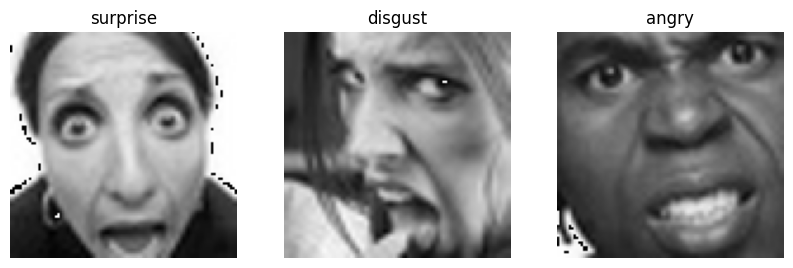

Validation sample:


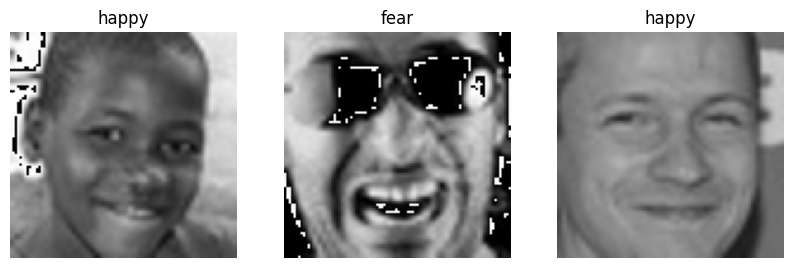

Test sample:


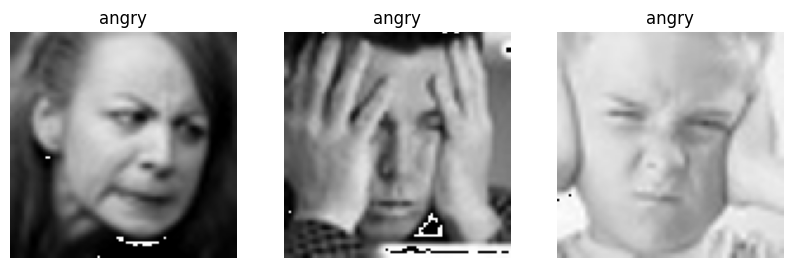

In [7]:
import tensorflow as tf

def grayscale_to_rgb_and_resize(image, label, target_size=(96,96)):
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, target_size, method='bicubic') 
    return image, label

train_ds_rgb = train_ds.map(grayscale_to_rgb_and_resize)
val_ds_rgb = val_ds.map(grayscale_to_rgb_and_resize)
test_ds_rgb = test_ds.map(grayscale_to_rgb_and_resize)


import matplotlib.pyplot as plt

def show_images(dataset, class_names, n=3):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  
        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy().argmax()])
            plt.axis("off")
    plt.show()

print("Train sample:")
show_images(train_ds_rgb, class_names)

print("Validation sample:")
show_images(val_ds_rgb, class_names)

print("Test sample:")
show_images(test_ds_rgb, class_names)

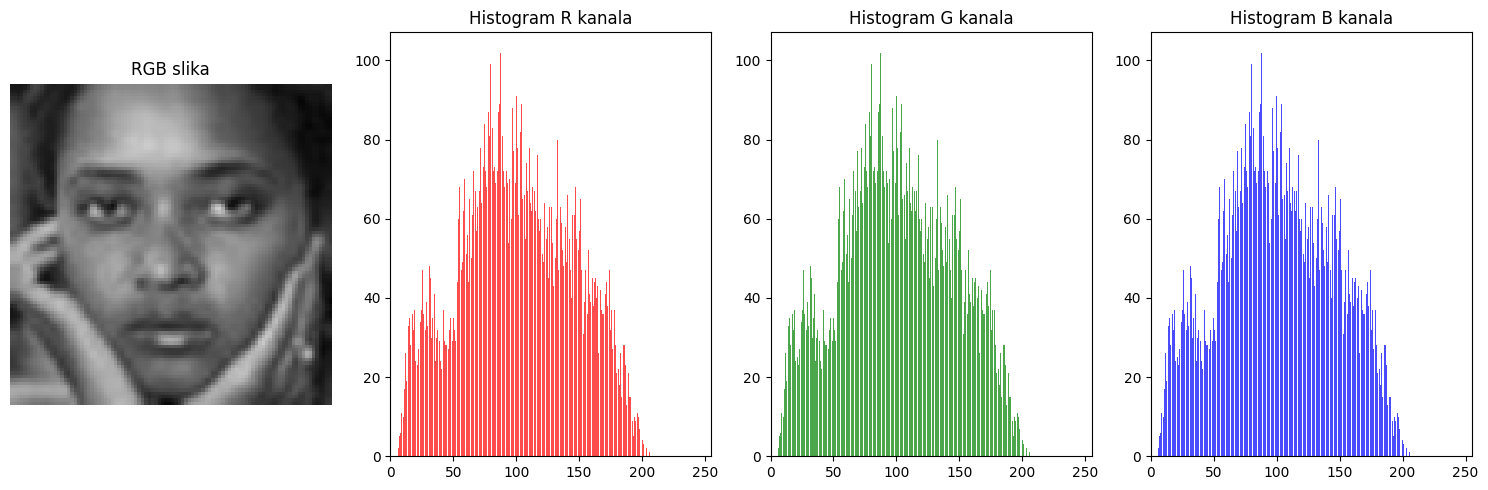

In [42]:
import matplotlib.pyplot as plt

for images, labels in train_ds_rgb.take(1):
    image = images[0].numpy().astype("uint8")  # prva slika
    break

plt.figure(figsize=(15,5))
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("RGB slika")
plt.axis("off")

# Histogram
colors = ("r", "g", "b")
for i, col in enumerate(colors):
    plt.subplot(1, 4, i+2)
    plt.hist(image[:, :, i].ravel(), bins=256, color=col, alpha=0.7)
    plt.title(f"Histogram {col.upper()} kanala")
    plt.xlim([0, 255])

plt.tight_layout()
plt.show()


In [43]:
#Class weight calculation
import numpy as np
from sklearn.utils import class_weight

y_train_int = []
for _, y in train_ds_rgb.unbatch():        
    y_train_int.append(np.argmax(y.numpy()))
y_train_int = np.array(y_train_int)


class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)

class_weights = dict(enumerate(class_weights_array))
print(class_weights)


{0: np.float64(1.1586904016459434), 1: np.float64(1.1565178571428572), 2: np.float64(1.127622529816314), 3: np.float64(0.6457611486402274), 4: np.float64(0.9286968990858577), 5: np.float64(0.9369258589511754), 6: np.float64(1.4433920213951414)}


In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
#     layers.RandomTranslation(0.1, 0.1),
#     layers.RandomContrast(0.2),
#     layers.RandomBrightness(0.2)
# ])


# def augment(image, label):
#     image = data_augmentation(image, training=True)
#     return image, label


# rare_class_repeat = {
#     'fear': 3,
#     'surprise': 3,
#     'angry': 2,
#     'disgust': 2,
#     'happy': 1,
#     'sad': 1,
#     'neutral': 1
# }


# train_ds_rgb = train_ds_rgb.unbatch()  # radimo po primerku

# augmented_datasets = []

# for rare_class, repeat_num in rare_class_repeat.items():
#     rare_idx = train_class_names.index(rare_class)
    
#     # Dataset sa samo retkom klasom
#     rare_ds = train_ds_rgb.filter(lambda x, y, idx=rare_idx: tf.equal(tf.argmax(y), idx))
#     # Repeat pre map da izbegnemo pickle greške
#     rare_ds = rare_ds.repeat(repeat_num).map(augment)
    
#     augmented_datasets.append(rare_ds)

# # Dataset sa ostalim klasama
# common_ds = train_ds_rgb.filter(lambda x, y: ~tf.reduce_any(
#     tf.equal(tf.argmax(y), [train_class_names.index(c) for c in rare_class_repeat.keys()])
# ))

# # Spajanje dataset-a
# train_ds_rgb = common_ds
# for ds in augmented_datasets:
#     train_ds_rgb = train_ds_rgb.concatenate(ds)

# train_ds_rgb = train_ds_rgb.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# count = sum(images.shape[0] for images, labels in train_ds_rgb)
# val_count = sum(images.shape[0] for images, labels in val_ds_rgb)
# test_count = sum(images.shape[0] for images, labels in test_ds_rgb)

# print("Train:", count, "Validation:", val_count, "Test:", test_count)

<h1 style="color: #16537e">MOBILENET V2</h1>

In [44]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

class_weights = {0:2, 1:1, 2:2, 3:1, 4:1, 5:2, 6:1}
# Base model
base_model = MobileNetV2(
    input_shape=(96,96,3),
    include_top=False,    
    weights='imagenet'    
)

for layer in base_model.layers:
    layer.trainable = False

inputs = layers.Input(shape=(96,96,3))
x = data_augmentation(inputs)    
x = tf.keras.applications.mobilenet.preprocess_input(inputs)

x = base_model(x, training=False)      
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("mobilenet.keras", monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

#Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=100,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    class_weight = class_weights
)


loss, acc, prec, rec, auc = model.evaluate(test_ds_rgb)
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")


Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 36s 166ms/step - accuracy: 0.2383 - auc: 0.6339 - loss: 2.5793 - precision: 0.3638 - recall: 0.0223 - val_accuracy: 0.3570 - val_auc: 0.7409 - val_loss: 1.6778 - val_precision: 0.7593 - val_recall: 0.0190 - learning_rate: 0.0010
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 34s 165ms/step - accuracy: 0.3222 - auc: 0.7115 - loss: 2.3593 - precision: 0.6250 - recall: 0.0655 - val_accuracy: 0.3862 - val_auc: 0.7604 - val_loss: 1.6188 - val_precision: 0.7305 - val_recall: 0.0418 - learning_rate: 0.0010
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 33s 162ms/step - accuracy: 0.3539 - auc: 0.7384 - loss: 2.2820 - precision: 0.6477 - recall: 0.0933 - val_accuracy: 0.4289 - val_auc: 0.7945 - val_loss: 1.5239 - val_precision: 0.8009 - val_recall: 0.0863 - learning_rate: 0.0010
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 31s 153ms/step - accuracy: 0.3764 - auc: 0.7573 - loss: 2.2205 - precision: 0.6813 - recall: 0.1180 - val_accuracy: 0.4544 - val_auc: 0.8163 - val_lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━

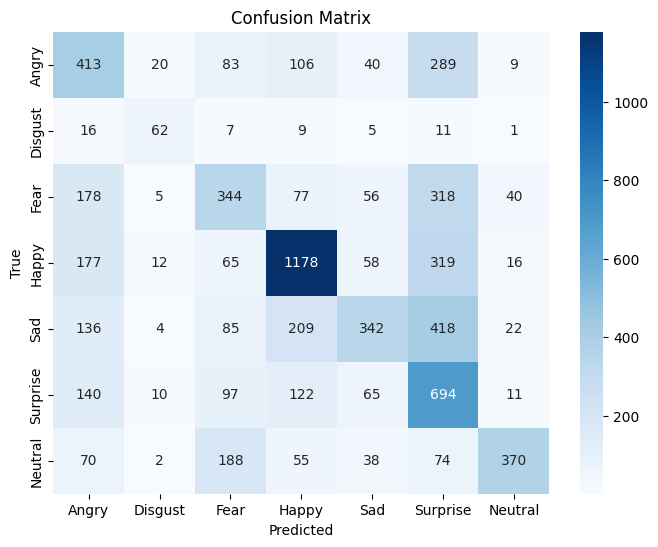

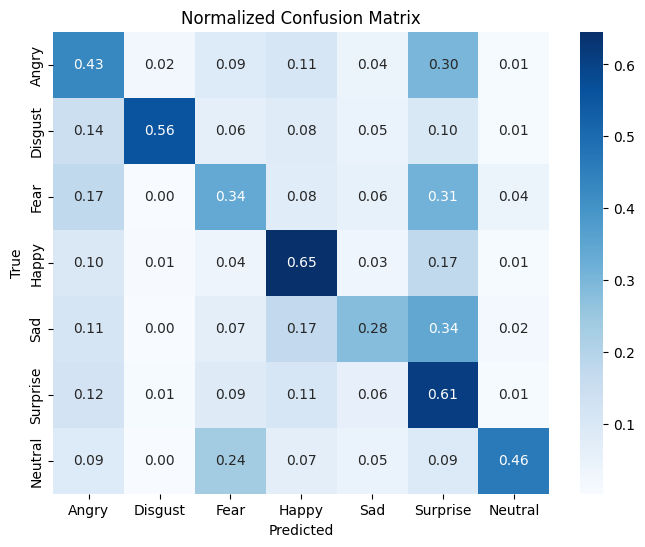

              precision    recall  f1-score   support

       Angry       0.37      0.43      0.40       960
     Disgust       0.54      0.56      0.55       111
        Fear       0.40      0.34      0.36      1018
       Happy       0.67      0.65      0.66      1825
         Sad       0.57      0.28      0.38      1216
    Surprise       0.33      0.61      0.43      1139
     Neutral       0.79      0.46      0.58       797

    accuracy                           0.48      7066
   macro avg       0.52      0.48      0.48      7066
weighted avg       0.53      0.48      0.48      7066

F1 score: 0.4788932460482592


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

y_true = []
y_pred = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#Normalized confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()


#Report
print(classification_report(y_true, y_pred, target_names=class_names))
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("F1 score:", f1)


In [46]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

y_true = []
y_pred = []
y_pred_probs = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)

print(classification_report(y_true, y_pred, target_names=class_names))
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro F1 score:", f1)

weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted F1 score:", weighted_f1)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro precision:", macro_precision)
weighted_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted precision:", weighted_precision)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro recall:", macro_recall)
weighted_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted recall:", weighted_recall)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
auc_global = roc_auc_score(np.eye(len(class_names))[y_true], y_pred_probs, multi_class='ovr')
print("AUC score:", auc_global)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━

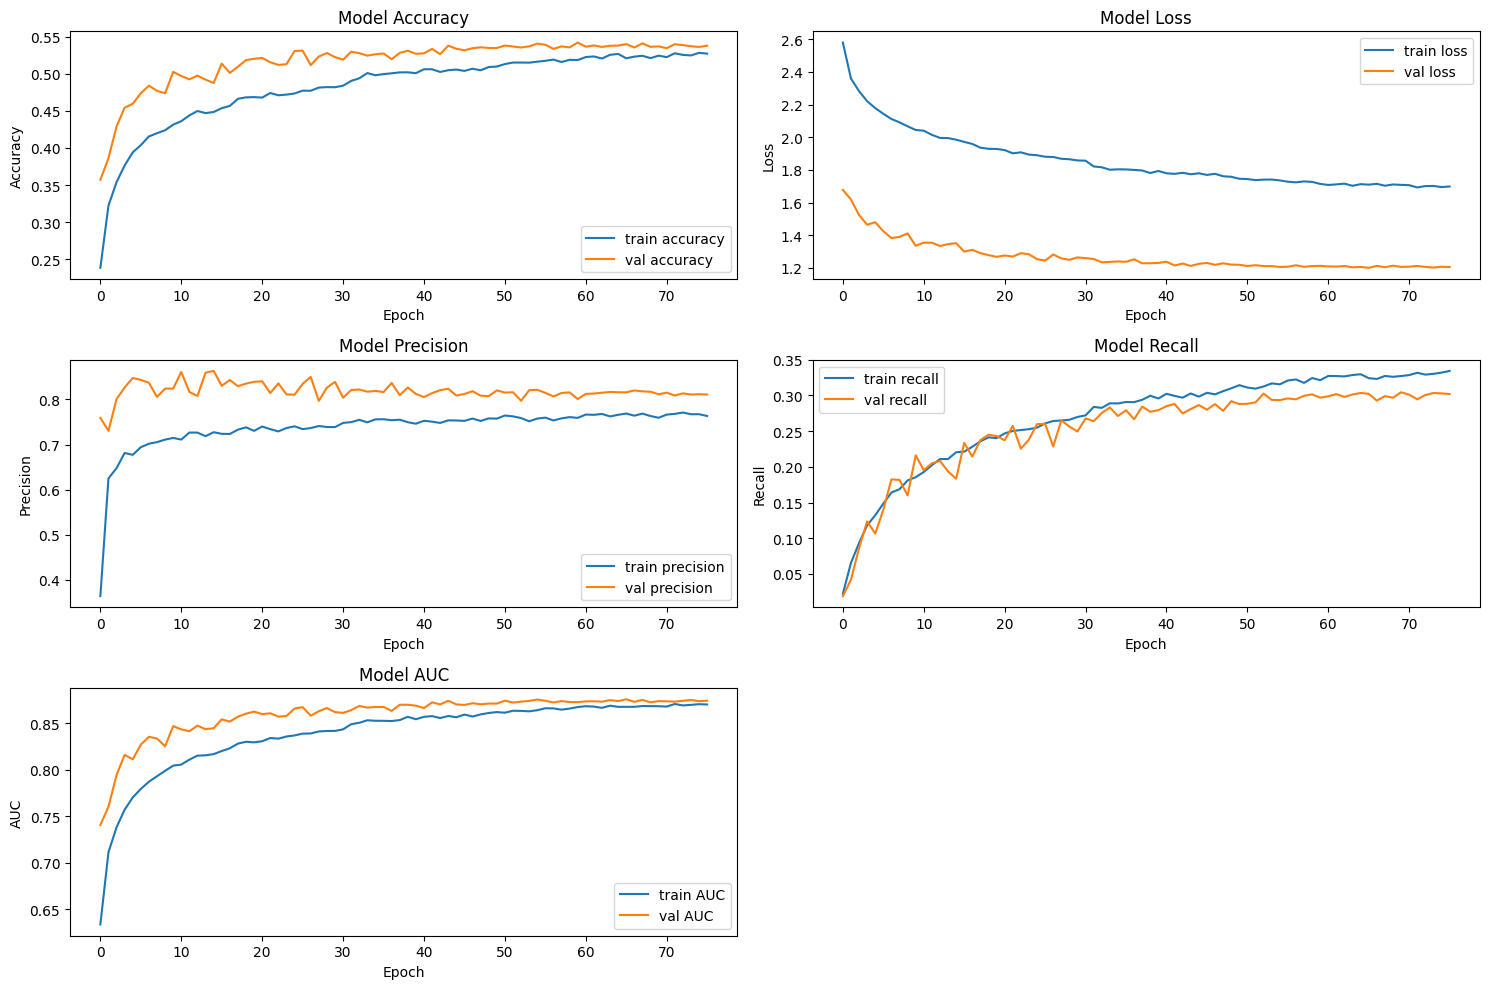

In [47]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()

In [48]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,752,599 (10.50 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 329,744 (1.26 MB)

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 24, 24,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 24, 24,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 24, 24,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 24, 24,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 24, 24,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 24, 24,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 25, 25,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 12, 12,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 12, 12,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [49]:
set_trainable = False
for layer in base_model.layers:
    if layer.name.startswith("block_16"):
        set_trainable = True
    if set_trainable:
        # BatchNorm ostaje zamrznut
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

history_finetune = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=100,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

loss, acc, prec, rec, auc = model.evaluate(test_ds_rgb)
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")

Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 49s 228ms/step - accuracy: 0.5382 - auc: 0.8742 - loss: 1.2040 - precision: 0.7638 - recall: 0.3444 - val_accuracy: 0.5541 - val_auc: 0.8806 - val_loss: 1.1741 - val_precision: 0.7726 - val_recall: 0.3592 - learning_rate: 5.0000e-05
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 48s 235ms/step - accuracy: 0.5543 - auc: 0.8849 - loss: 1.1553 - precision: 0.7811 - recall: 0.3668 - val_accuracy: 0.5754 - val_auc: 0.8911 - val_loss: 1.1284 - val_precision: 0.8096 - val_recall: 0.3609 - learning_rate: 5.0000e-05
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - accuracy: 0.5806 - auc: 0.8953 - loss: 1.1034 - precision: 0.7900 - recall: 0.3953 - val_accuracy: 0.5822 - val_auc: 0.8936 - val_loss: 1.1154 - val_precision: 0.8082 - val_recall: 0.3630 - learning_rate: 5.0000e-05
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 51s 251ms/step - accuracy: 0.5896 - auc: 0.9021 - loss: 1.0687 - precision: 0.7972 - recall: 0.4100 - val_accuracy: 0.5837 - val_auc: 0.8

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

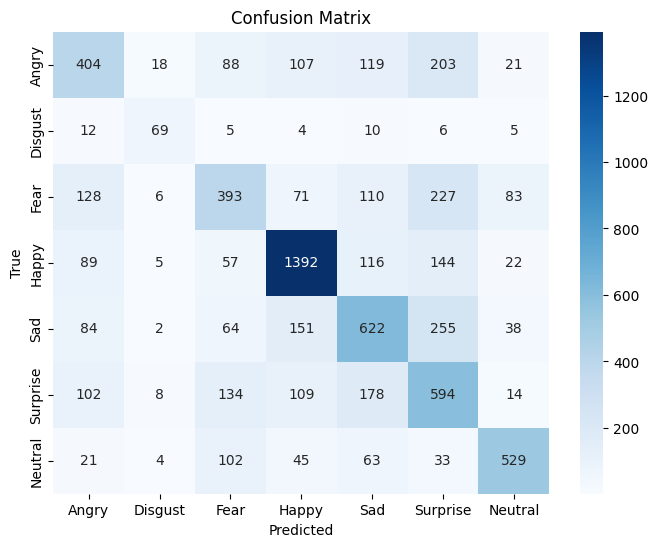

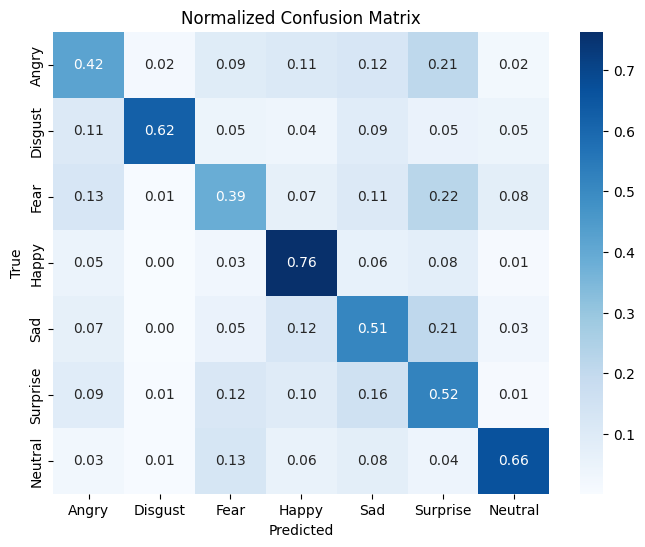

              precision    recall  f1-score   support

       Angry       0.48      0.42      0.45       960
     Disgust       0.62      0.62      0.62       111
        Fear       0.47      0.39      0.42      1018
       Happy       0.74      0.76      0.75      1825
         Sad       0.51      0.51      0.51      1216
    Surprise       0.41      0.52      0.46      1139
     Neutral       0.74      0.66      0.70       797

    accuracy                           0.57      7066
   macro avg       0.57      0.56      0.56      7066
weighted avg       0.57      0.57      0.57      7066

F1 score: 0.5586661776246163


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

y_true = []
y_pred = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

#Confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#Normalized confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()


#Report
print(classification_report(y_true, y_pred, target_names=class_names))
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("F1 score:", f1)


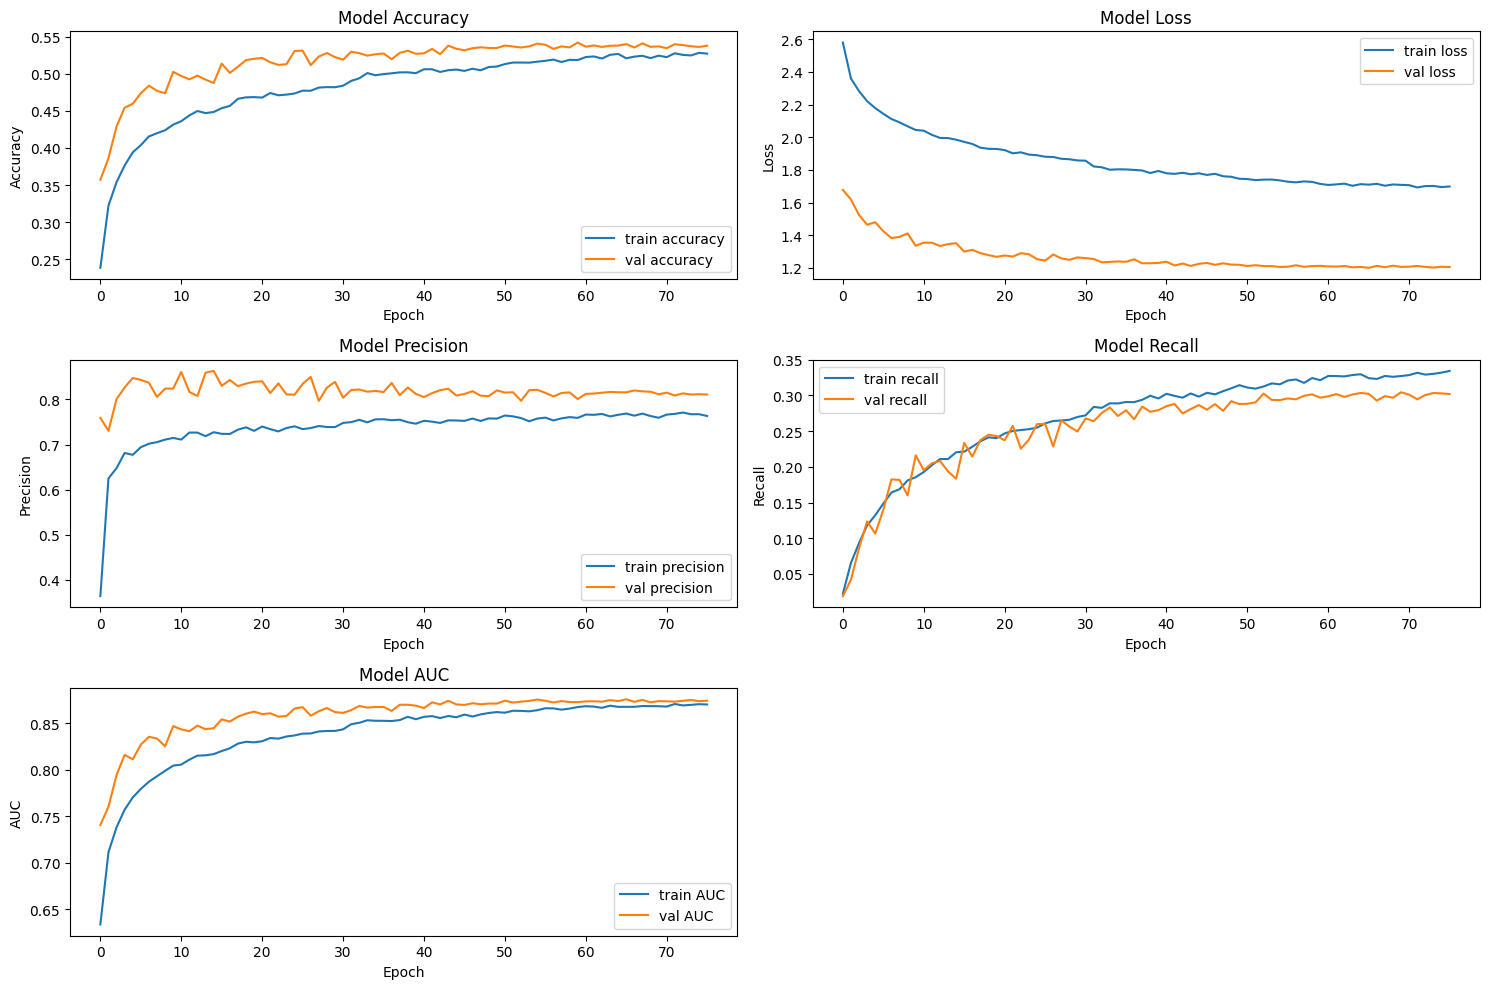

In [51]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
# from tensorflow.keras.models import load_model

# model = load_model("mobilenet.keras")


y_true = []
y_pred = []
y_pred_probs = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro F1 score:", f1)

weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted F1 score:", weighted_f1)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro precision:", macro_precision)
weighted_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted precision:", weighted_precision)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro recall:", macro_recall)
weighted_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted recall:", weighted_recall)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
auc_global = roc_auc_score(np.eye(len(class_names))[y_true], y_pred_probs, multi_class='ovr')
print("AUC score:", auc_global)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━

In [53]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,510,679 (17.21 MB)

 Trainable params: 1,043,911 (3.98 MB)

 Non-trainable params: 1,378,944 (5.26 MB)

 Optimizer params: 2,087,824 (7.96 MB)